# Example 2: Recidivism

We will use the Rossi dataset which contains 432 convicts who were released from MD state prisons and who were followed up for one year after release. Half the released convicts were assigned at random to an test set; half were assigned to a control group.

In [1]:
from lifelines.datasets import load_rossi
recidivism = load_rossi()
recidivism.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
import pandas as pd
import numpy as np

pd.DataFrame({'dtypes': recidivism.dtypes,
             'nunique': recidivism.nunique()})

,dtypes,nunique
week,int64,49
arrest,int64,2
fin,int64,2
age,int64,28
race,int64,2
wexp,int64,2
mar,int64,2
paro,int64,2
prio,int64,17


In [3]:
recidivism.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


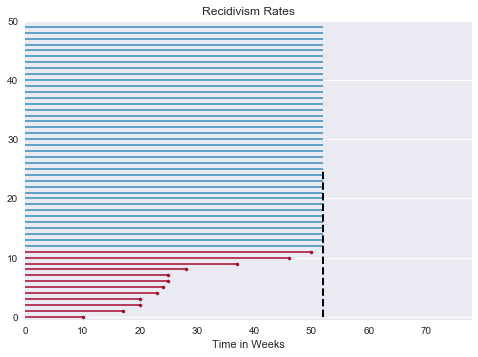

In [5]:
# plot "lifelines" of the participants as they attempt to avoid recidivism

import lifelines
import matplotlib.pyplot as plt # version > 3.0
plt.style.use('seaborn')

duration = recidivism.week.values[:50]
arrested = recidivism.arrest.values[:50]

ax = lifelines.plotting.plot_lifetimes(durations=duration, event_observed=arrested)
ax.set_xlim(0, 78)
ax.grid(axis='x')
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.set_xlabel("Time in Weeks")
ax.set_title("Recidivism Rates");
plt.plot();

# Kaplan-Meier Survival Estimate

In [6]:
duration = recidivism.week.values
arrested = recidivism.arrest.values

kmf = lifelines.KaplanMeierFitter()
kmf.fit(duration,arrested)

<lifelines.KaplanMeierFitter: fitted with 432 observations, 318 censored>

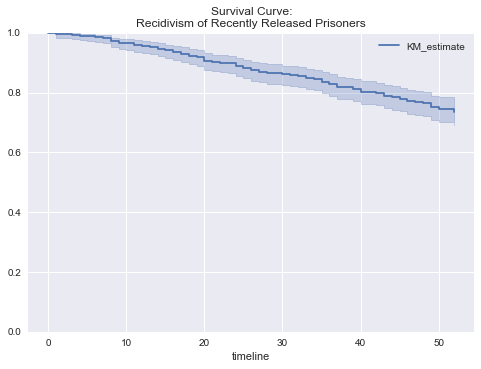

In [7]:
# overall survival function

kmf.plot()
#kmf.survival_function_.plot()
#kmf.plot_survival_function()
plt.title('Survival Curve:\nRecidivism of Recently Released Prisoners')
plt.ylim(0,1);

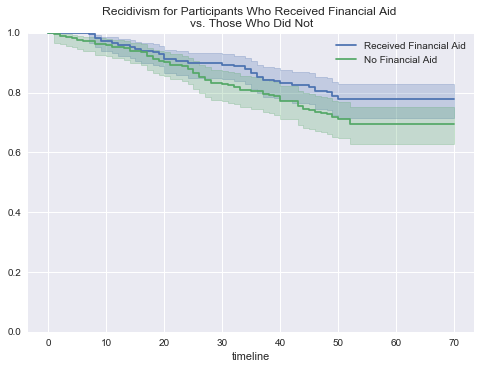

In [8]:
# investigate a specific categorical variable

kmf_w_aid = lifelines.KaplanMeierFitter()
kmf_no_aid = lifelines.KaplanMeierFitter()

ax = plt.subplot(111)

w_aid = (recidivism['fin']==1)

t = np.linspace(0, 70, 71)
kmf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid], 
              timeline=t, label="Received Financial Aid")
ax = kmf_w_aid.plot(ax=ax)
#print("Median survival time of democratic:", kmf.median_)

kmf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid], 
               timeline=t, label="No Financial Aid")
ax = kmf_no_aid.plot(ax=ax)
#print("Median survival time of non-democratic:", kmf.median_)

plt.ylim(0,1)
plt.title("Recidivism for Participants Who Received Financial Aid \nvs. Those Who Did Not");

# Cox Proportional Hazards Model -- Survival Regression

In [9]:
# cox proportional hazards model

cph = lifelines.CoxPHFitter()
cph.fit(df=recidivism, duration_col='week', event_col='arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-04-24 14:15:52 UTC

---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
fin  -0.38      0.68      0.19 -1.98   0.05      4.40       -0.75       -0.00
age  -0.06      0.94      0.02 -2.61   0.01      6.79       -0.10       -0.01
race  0.31      1.37      0.31  1.02   0.31      1.70       -0.29        0.92
wexp -0.15      0.86      0.21 -0.71   0.48      1.06       -0.57        0.27
mar  -0.43      0.65      0.38 -1.14   0.26      1.97       -1.18        0.31
paro -0.08      0.92      0.20 -0.43   0.66      0.59       -0.47        0.30
prio  0.09      1.10      0.03  3.19 <0.005      9.48        0.04        0.15
---
Concordance = 0.64
Log-likelihood ratio test = 33.27 on 7 df, -log2(p)=15.37


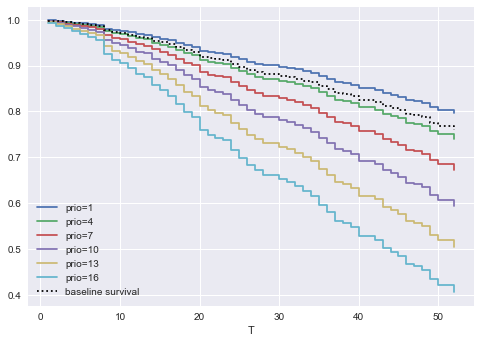

In [10]:
# investigate continuous feature, must bin with "value" argument

cph.plot_covariate_groups(covariates='prio', values=np.arange(1,19,3))

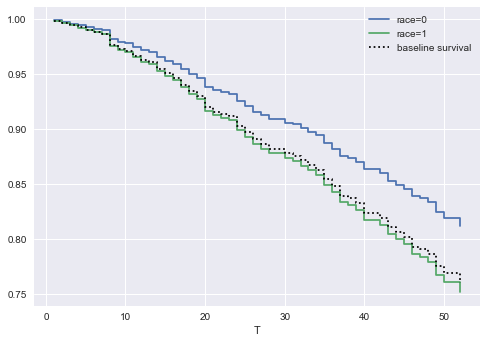

In [11]:
# categorical feature

cph.plot_covariate_groups(covariates='race', values=[0,1])

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.09 <0.005     10.17
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.16
mar  km              0.60   0.44      1.19
    

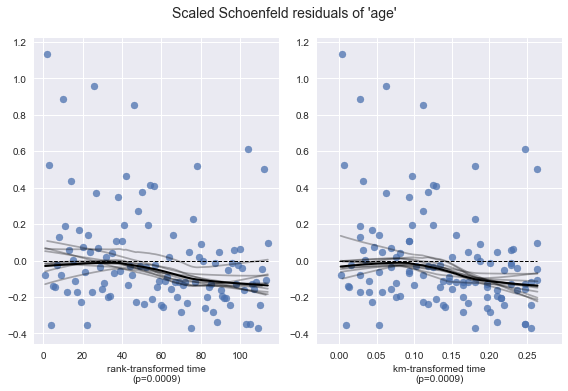

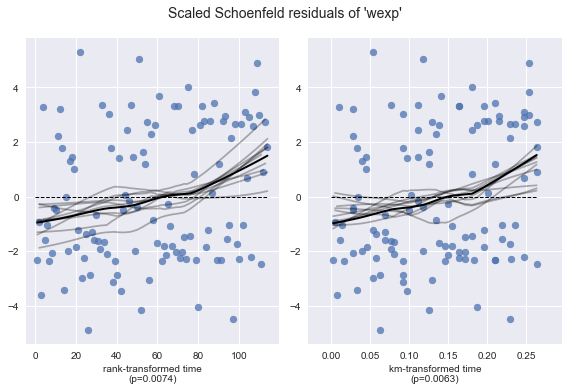

In [12]:
# check model assumption

cph.check_assumptions(recidivism, show_plots=True)

# Checking Assumption

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
           test_statistic      p  -log2(p)
age  km             11.29 <0.005     10.32
     rank            4.62   0.03      4.99
fin  km              0.02   0.90      0.16
     rank            0.05   0.83      0.28
mar  km              0.53   0.47      1.10
    

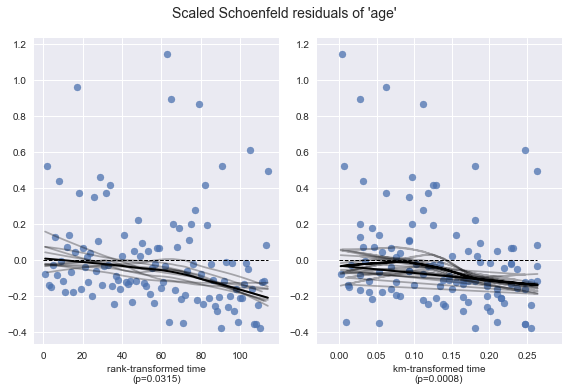

In [13]:
# fixing for the assumptions

cph.fit(df=recidivism, duration_col='week', event_col='arrest', strata=['wexp'])
cph.check_assumptions(recidivism, show_plots=True)

Since age is still violating the proportional hazard assumption, we need to model it better. From the residual plots above, we can see a the effect of age start to become negative over time. This will be relevant later. Below, we present three options to handle age.

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -579.37
  time fit was run = 2019-04-24 14:16:49 UTC
             model = quad and cubic age terms


---
        coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
fin    -0.37      0.69      0.19 -1.93   0.05      4.24       -0.75        0.00
age    -0.06      0.94      0.03 -1.85   0.06      3.95       -0.13        0.00
race    0.35      1.42      0.31  1.13   0.26      1.95       -0.26        0.95
mar    -0.39      0.68      0.38 -1.02   0.31      1.70       -1.15        0.36
paro   -0.10      0.90      0.20 -0.52   0.60      0.74       -0.49        0.28
prio    0.09      1.10      0.03  3.22 <0.005      9.59        0.04        0.15
age**2  0.01      1.01      0.00  1.57   0.12      3.09       -0.00        0.02
age**3 -0.00      1.00      

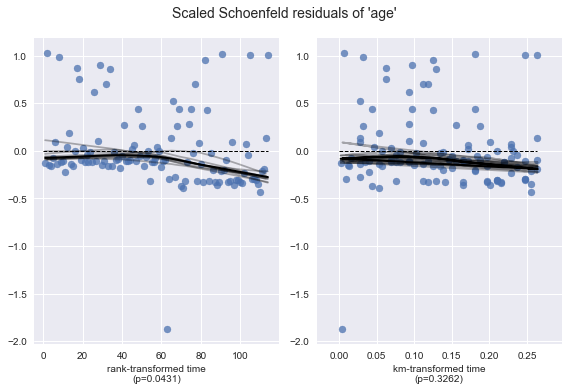

In [14]:
# option 1 -- modify the function form
# we can add quadratic or cubic terms 

recidivism_higher_order_age = recidivism.copy()
recidivism_higher_order_age['age'] = recidivism_higher_order_age['age'] - recidivism_higher_order_age['age'].mean()
recidivism_higher_order_age['age**2'] = (recidivism_higher_order_age['age'] - recidivism_higher_order_age['age'].mean())**2
recidivism_higher_order_age['age**3'] = (recidivism_higher_order_age['age'] - recidivism_higher_order_age['age'].mean())**3

cph.fit(recidivism_higher_order_age, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="quad and cubic age terms"); print()
cph.check_assumptions(recidivism_higher_order_age, show_plots=True, p_value_threshold=0.05)

We see we still have potentially some violation, but it’s a heck of a lot less. Also, interestingly, when we include these non-linear terms for age, the wexp proportionality violation disappears. It is not uncommon to see changing the functional form of one variable effects other’s proportional tests, usually positively. 

In [15]:
# option 2 -- bin variable and stratify on it
# the second option proposed is to bin the variable into equal-sized bins, and stratify like we did with wexp.

recidivism_strata_age = recidivism.copy()
recidivism_strata_age['age_strata'] = pd.cut(recidivism_strata_age['age'], np.arange(0, 80, 3))
recidivism_strata_age[['age', 'age_strata']].head()

# drop the orignal, redundant, age column
recidivism_strata_age = recidivism_strata_age.drop('age', axis=1)
cph.fit(recidivism_strata_age, 'week', 'arrest', strata=['age_strata', 'wexp'])
cph.print_summary(model="strata age"); print()
cph.check_assumptions(recidivism_strata_age, show_plots=True, p_value_threshold=0.05)

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata', 'wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -392.44
  time fit was run = 2019-04-24 14:16:55 UTC
             model = strata age


---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
fin  -0.40      0.67      0.20 -2.00   0.05      4.47       -0.78       -0.01
race  0.28      1.32      0.31  0.89   0.37      1.43       -0.33        0.89
mar  -0.19      0.82      0.39 -0.49   0.62      0.69       -0.96        0.57
paro -0.16      0.85      0.20 -0.82   0.41      1.28       -0.55        0.23
prio  0.08      1.08      0.03  2.85 <0.005      7.86        0.03        0.14
---
Concordance = 0.58
Log-likelihood ratio test = 13.25 on 5 df, -log2(p)=5.56

Proportional hazard assumption looks okay.


In [16]:
# option 3 -- introducing time-varying covariates
# our second option to correct variables that violate the proportional hazard assumption is to model 
# the time-varying component directly. this is done in two steps, first is to transform your dataset into episodic format.
# this means that we split a subject from a single row into n new rows, and each new row represents some time period for
# the subject. 

from lifelines.utils import to_episodic_format
recidivism_long = to_episodic_format(recidivism, duration_col='week', event_col='arrest', time_gaps=1.)
recidivism_long.head(25)

,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


Each subject is given a new id (but can be specified as well if already provided in the dataframe). This id is used to track subjects over time. Notice the arrest col is 0 for all periods prior to their (possible) event as well.

Above I mentioned there were two steps to correct age. The first was to convert to a episodic format. The second is to create an interaction term between age and stop. This is a time-varying variable.

Instead of CoxPHFitter, we must use "Cox Time Varying Fitter" instead since we are working with a episodic dataset.

In [17]:
recidivism_long['time*age'] = recidivism_long['age'] * recidivism_long['stop']
recidivism_long = recidivism_long.drop('age', axis=1)

ctv = lifelines.CoxTimeVaryingFitter()
ctv.fit(recidivism_long,
        id_col='id',
        event_col='arrest',
        start_col='start',
        stop_col='stop',
        strata=['wexp'])

ctv.print_summary(3, model="age * time interaction")

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
 number of periods = 19809
  number of events = 114
    log-likelihood = -576.590
  time fit was run = 2019-04-24 14:17:04 UTC
             model = age * time interaction


---
           coef exp(coef)  se(coef)      z       p  -log2(p)  lower 0.95  upper 0.95
fin      -0.374     0.688     0.191 -1.957   0.050     4.311      -0.748       0.001
mar      -0.391     0.676     0.382 -1.023   0.306     1.706      -1.140       0.358
paro     -0.107     0.899     0.196 -0.546   0.585     0.773      -0.490       0.277
prio      0.091     1.096     0.029  3.175   0.002     9.380       0.035       0.148
race      0.310     1.363     0.308  1.005   0.315     1.668      -0.294       0.914
time*age -0.003     0.997     0.001 -3.531 <0.0005    11.236      -0.004      -0.001
---
Log-likelihood ratio test = 32.366 on 6 df, -log2(p)=

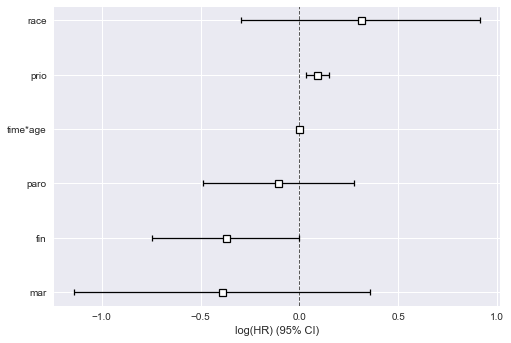

In [18]:
ctv.plot()

# Nelson-Aalen Estimator

          NA_estimate
timeline             
0.0          0.000000
1.0          0.002315
2.0          0.004635
3.0          0.006961
4.0          0.009292


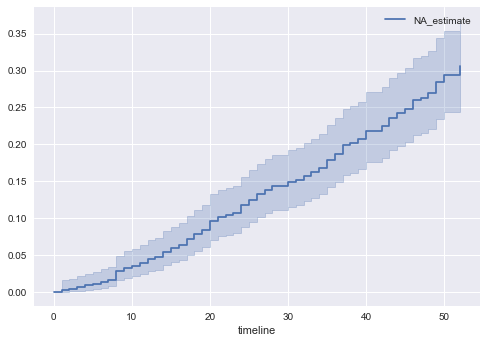

In [19]:
naf = lifelines.NelsonAalenFitter()
naf.fit(duration, arrested)

print(naf.cumulative_hazard_.head())
naf.plot();

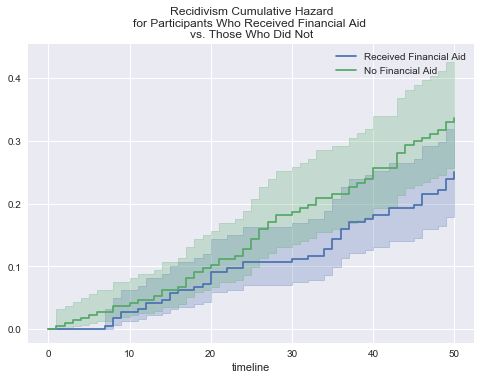

In [20]:
# Nelson Aalen Model with categorical variable

naf_w_aid = lifelines.NelsonAalenFitter()
naf_no_aid = lifelines.NelsonAalenFitter()

naf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid], 
              timeline=t, label="Received Financial Aid")
ax = naf_w_aid.plot(loc=slice(0, 50))

naf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid], 
               timeline=t, label="No Financial Aid")
ax = naf_no_aid.plot(ax=ax, loc=slice(0, 50))

plt.title("Recidivism Cumulative Hazard\n"
          "for Participants Who Received Financial Aid \n"
          "vs. Those Who Did Not");